In [2]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.dates as mdates
import datetime as dt

In [3]:
# Reading the data from the .csv file.

doge_df = pd.read_csv("data/DOGE-USD.csv")

# Viewing the dataframe.

doge_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550.0
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520.0
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080.0
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960.0
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270.0


In [4]:
# Sorting values by date.

doge_df = doge_df.sort_values('Date')

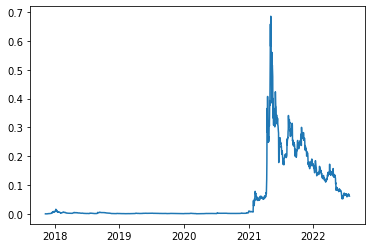

In [5]:
# Visualizing price action over the years.

x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in doge_df["Date"]]
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.plot(x, doge_df["Close"])
plt.show()

In [6]:
# Removing nan values from dataset.

doge_df = doge_df.dropna()

In [9]:
# Preparation of training set.

close_prices = doge_df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
# Preparation of test set.

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [11]:
# Setting Up LSTM Network Architecture.

model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 25)                2525      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Training LSTM Model.

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1318/1318 [==============================] - 72s 54ms/step - loss: 0.0032
Epoch 2/3
1318/1318 [==============================] - 71s 54ms/step - loss: 0.0023
Epoch 3/3
1318/1318 [==============================] - 71s 54ms/step - loss: 0.0011


In [17]:
# Predictions of test dataset.

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [33]:
# Model Evaluation.

rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.008736776452665407

<ipython-input-32-339c3768b3de>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


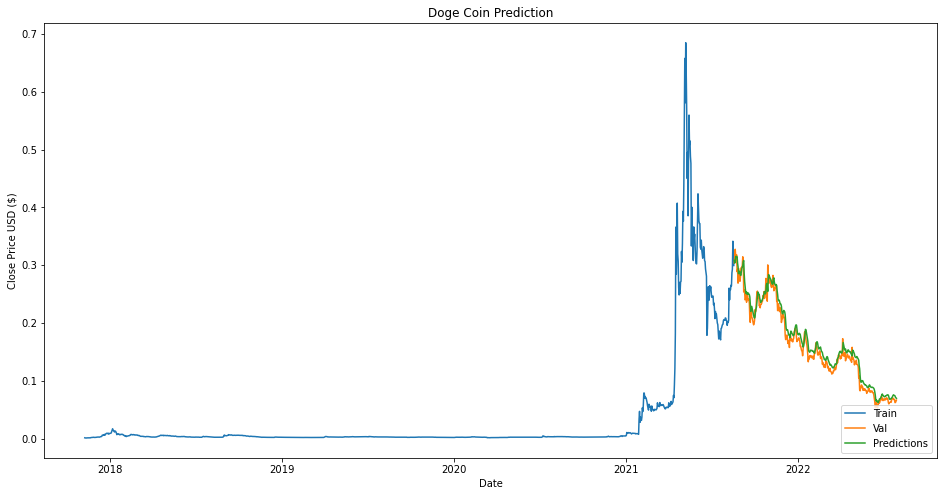

In [32]:
# Visualizing the Predicted Prices.

data = doge_df.filter(['Date','Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in train["Date"]]
x1 = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in validation["Date"]]
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Doge Coin Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(x,train['Close'])
plt.plot(x1,validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()